In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load training data

In [19]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

train_raw = pd.read_csv(os.path.join('..', 'data', 'train.csv'))
Y = train_raw['SalePrice']
train_raw.drop('SalePrice', axis=1, inplace=True)

### Playing with linear model + scikit-learn

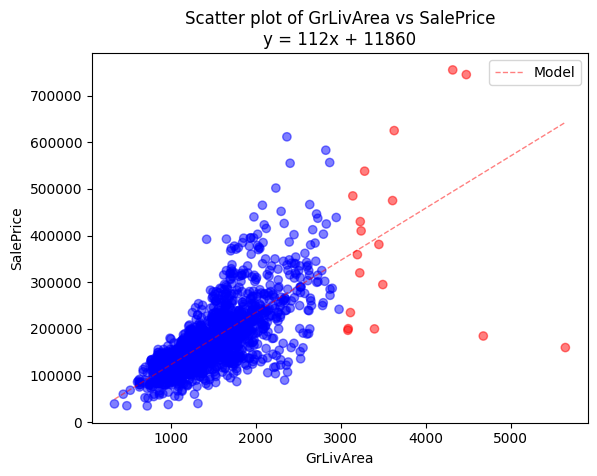

In [22]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# xfeature = 'LotArea'
xfeature = 'GrLivArea'
yfeature = 'SalePrice'

# organize the training data
sorted_df = pd.DataFrame({
    xfeature: train_raw[xfeature],
    'Y': Y
}).sort_values(by=xfeature).dropna()
Xt = sorted_df[xfeature].to_numpy().reshape(-1, 1)
Yt = sorted_df['Y'].to_numpy().reshape(-1, 1)

cutoff = 3000

# remove outliers and prep model data
model_df = sorted_df[sorted_df[xfeature] < cutoff]
# model_df = sorted_df
Xmodel = model_df[xfeature].to_numpy().reshape(-1, 1)
Ymodel = model_df['Y'].to_numpy().reshape(-1, 1)

# create the model
linear_m = linear_model.LinearRegression();
linear_m.fit(Xmodel, Ymodel)

# make predictions
predictions = linear_m.predict(Xt)

# plot the model against the data
c = ['blue' if x < cutoff else 'red' for x in Xt]
plt.scatter(Xt, Yt, alpha=0.5, color=c)
plt.title(f'Scatter plot of {xfeature} vs {yfeature}\ny = {round(linear_m.coef_[0][0])}x + {round(linear_m.intercept_[0])}')
plt.xlabel(xfeature)
plt.ylabel(yfeature)

plt.plot(Xt, predictions, color='red', alpha=0.5, label='Model', ls='--', lw=1)
plt.legend()

plt.show()

### Prep features

In [21]:
tempVector = (train_raw.dtypes == 'object')
cat_cols = list(tempVector[tempVector].index)

tempVector = (train_raw.dtypes != 'object')
ncat_cols = list(tempVector[tempVector].index)


ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
sse = StandardScaler()

cat_cols_df = pd.DataFrame(ohe.fit_transform(train_raw[cat_cols]))
cat_cols_df.columns = [f'cf-{index}' for index in range(len(cat_cols_df.columns))]

ncat_cols_df = pd.DataFrame(sse.fit_transform(train_raw[ncat_cols]))
ncat_cols_df.columns = [f'ncf-{index}' for index in range(len(ncat_cols_df.columns))]

full_df = pd.concat([cat_cols_df, ncat_cols_df], axis=1)

# Handle missing values by adding indicator columns for nulls and filling with 0
null_df = full_df.isna()
l = null_df.any()
null_df = null_df[l[l==True].index] # only columns with nulls

# label the null columns
null_df.columns = [f'nicf-{index}' for index in range(len(null_df.columns))]

# fill the nulls with 0
full_df.fillna(0, inplace=True)

# add the null columns to the full dataframe
full_df = pd.concat([full_df, null_df], axis=1).astype(float)